In [1]:
import matplotlib.pyplot as plt
import numpy as np
import configparser
import sys

from astropy.table import Table

sys.path.append('../../')
import WD_models

config = configparser.ConfigParser()
config.read('../config.ini')

catalog = Table.read('../out.csv')

In [2]:
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
speed_light = 299792458 #m/s

def one_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    ONe_model = WD_models.load_model('ft', 'ft', 'o', atm_type = 'H', HR_bands = ['bp3-rp3', 'G3'])
    g_acc = (10**ONe_model['logg'])/100
    rsun = np.sqrt(ONe_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**ONe_model['logteff'],\
                                                z = ONe_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

def co_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    CO_model = WD_models.load_model('ft', 'ft', 'ft', atm_type = 'H', HR_bands = ['bp3-rp3', 'G3'])
    g_acc = (10**CO_model['logg'])/100
    rsun = np.sqrt(CO_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**CO_model['logteff'],\
                                                z = CO_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

In [3]:
radii = ['CO_Hdef', 'CO_Hrich', 'ONe_Hdef', 'ONe_Hrich', 'Warwick']
colors = ['blue', 'orange', 'green', 'red', 'teal']

rad_array = np.linspace(0.0045, 0.007, 100)
vg_array_one = one_model(rad_array, 16278)
vg_array_co = co_model(rad_array, 16278)

In [4]:
catalog

wd_solution_id,ms_solution_id,wd_source_id,ms_source_id,wd_random_index,ms_random_index,wd_ref_epoch,ms_ref_epoch,wd_ra,ms_ra,wd_ra_error,ms_ra_error,wd_dec,ms_dec,wd_dec_error,ms_dec_error,wd_parallax,ms_parallax,wd_parallax_error,ms_parallax_error,wd_parallax_over_error,ms_parallax_over_error,wd_pm,ms_pm,wd_pmra,ms_pmra,wd_pmra_error,ms_pmra_error,wd_pmdec,ms_pmdec,wd_pmdec_error,ms_pmdec_error,wd_ra_dec_corr,ms_ra_dec_corr,wd_ra_parallax_corr,ms_ra_parallax_corr,wd_ra_pmra_corr,ms_ra_pmra_corr,wd_ra_pmdec_corr,ms_ra_pmdec_corr,wd_dec_parallax_corr,ms_dec_parallax_corr,wd_dec_pmra_corr,ms_dec_pmra_corr,wd_dec_pmdec_corr,ms_dec_pmdec_corr,wd_parallax_pmra_corr,ms_parallax_pmra_corr,wd_parallax_pmdec_corr,ms_parallax_pmdec_corr,wd_pmra_pmdec_corr,ms_pmra_pmdec_corr,wd_astrometric_n_obs_al,ms_astrometric_n_obs_al,wd_astrometric_n_obs_ac,ms_astrometric_n_obs_ac,wd_astrometric_n_good_obs_al,ms_astrometric_n_good_obs_al,wd_astrometric_n_bad_obs_al,ms_astrometric_n_bad_obs_al,wd_astrometric_gof_al,ms_astrometric_gof_al,wd_astrometric_chi2_al,ms_astrometric_chi2_al,wd_astrometric_excess_noise,ms_astrometric_excess_noise,wd_astrometric_excess_noise_sig,ms_astrometric_excess_noise_sig,wd_astrometric_params_solved,ms_astrometric_params_solved,wd_astrometric_primary_flag,ms_astrometric_primary_flag,wd_nu_eff_used_in_astrometry,ms_nu_eff_used_in_astrometry,wd_pseudocolour,ms_pseudocolour,wd_pseudocolour_error,ms_pseudocolour_error,wd_ra_pseudocolour_corr,ms_ra_pseudocolour_corr,wd_dec_pseudocolour_corr,ms_dec_pseudocolour_corr,wd_parallax_pseudocolour_corr,ms_parallax_pseudocolour_corr,wd_pmra_pseudocolour_corr,ms_pmra_pseudocolour_corr,wd_pmdec_pseudocolour_corr,ms_pmdec_pseudocolour_corr,wd_astrometric_matched_transits,ms_astrometric_matched_transits,wd_visibility_periods_used,ms_visibility_periods_used,wd_astrometric_sigma5d_max,ms_astrometric_sigma5d_max,wd_matched_transits,ms_matched_transits,wd_new_matched_transits,ms_new_matched_transits,wd_matched_transits_removed,ms_matched_transits_removed,wd_ipd_gof_harmonic_amplitude,ms_ipd_gof_harmonic_amplitude,wd_ipd_gof_harmonic_phase,ms_ipd_gof_harmonic_phase,wd_ipd_frac_multi_peak,ms_ipd_frac_multi_peak,wd_ipd_frac_odd_win,ms_ipd_frac_odd_win,wd_ruwe,ms_ruwe,wd_scan_direction_strength_k1,ms_scan_direction_strength_k1,wd_scan_direction_strength_k2,ms_scan_direction_strength_k2,wd_scan_direction_strength_k3,ms_scan_direction_strength_k3,wd_scan_direction_strength_k4,ms_scan_direction_strength_k4,wd_scan_direction_mean_k1,ms_scan_direction_mean_k1,wd_scan_direction_mean_k2,ms_scan_direction_mean_k2,wd_scan_direction_mean_k3,ms_scan_direction_mean_k3,wd_scan_direction_mean_k4,ms_scan_direction_mean_k4,wd_duplicated_source,ms_duplicated_source,wd_phot_g_n_obs,ms_phot_g_n_obs,wd_phot_g_mean_flux,ms_phot_g_mean_flux,wd_phot_g_mean_flux_error,ms_phot_g_mean_flux_error,wd_phot_g_mean_flux_over_error,ms_phot_g_mean_flux_over_error,wd_phot_g_mean_mag,ms_phot_g_mean_mag,wd_phot_bp_n_obs,ms_phot_bp_n_obs,wd_phot_bp_mean_flux,ms_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,ms_phot_bp_mean_flux_error,wd_phot_bp_mean_flux_over_error,ms_phot_bp_mean_flux_over_error,wd_phot_bp_mean_mag,ms_phot_bp_mean_mag,wd_phot_rp_n_obs,ms_phot_rp_n_obs,wd_phot_rp_mean_flux,ms_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,ms_phot_rp_mean_flux_error,wd_phot_rp_mean_flux_over_error,ms_phot_rp_mean_flux_over_error,wd_phot_rp_mean_mag,ms_phot_rp_mean_mag,wd_phot_bp_n_contaminated_transits,ms_phot_bp_n_contaminated_transits,wd_phot_bp_n_blended_transits,ms_phot_bp_n_blended_transits,wd_phot_rp_n_contaminated_transits,ms_phot_rp_n_contaminated_transits,wd_phot_rp_n_blended_transits,ms_phot_rp_n_blended_transits,wd_phot_proc_mode,ms_phot_proc_mode,wd_phot_bp_rp_excess_factor,ms_phot_bp_rp_excess_factor,wd_bp_rp,ms_bp_rp,wd_bp_g,ms_bp_g,wd_g_rp,ms_g_rp,wd_dr2_radial_velocity,ms_dr2_radial_velocity,wd_dr2_radial_velocity_error,ms_dr2_radial_velocity_error,wd_dr2_rv_nb_transits,ms_dr2_rv_nb_transits,wd_dr2_rv_template_teff,ms_dr2

ONe_Hdef failed!


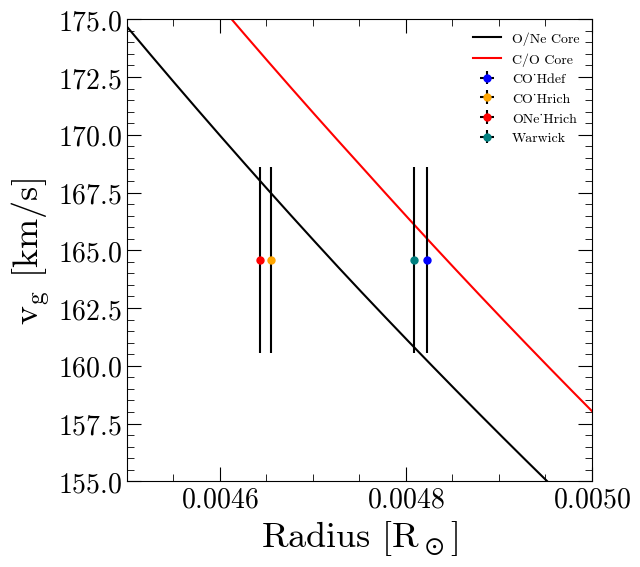

In [5]:
plt.style.use('../stefan.mplstyle')

plt.figure(figsize = (6,6))
plt.plot(rad_array, vg_array_one, label='O/Ne Core', color = 'k')
plt.plot(rad_array, vg_array_co, label='C/O Core', color = 'red')

for radius, color in zip(radii, colors):
    if not eval(catalog[f'{radius}_failed'][0]):
        plt.errorbar(catalog[f'{radius}_radius'], catalog['gravz'], 
                 xerr = catalog[f'{radius}_e_radius'], yerr = catalog['e_gravz'], 
                 fmt='o', label = f'{radius}', color=f'{color}', ecolor = 'black')
    else:
        print(f'{radius} failed!')

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'$v_g$ $[km/s]$')

plt.xlim(0.0045, 0.0050)
plt.ylim(155, 175)

plt.legend(framealpha=0, fontsize=10)
plt.show()

In [6]:
catalog['wd_source_id']

3121385658671190784


In [7]:
targets = Table.read('../targets.csv')

teffs = []
for row in targets:
    band = []
    for radius in radii:
        band.append(row[f'{radius}_teff'])

    teffs.append(np.mean(band))

Text(0.5, 0, '$\\log T_{eff}$')

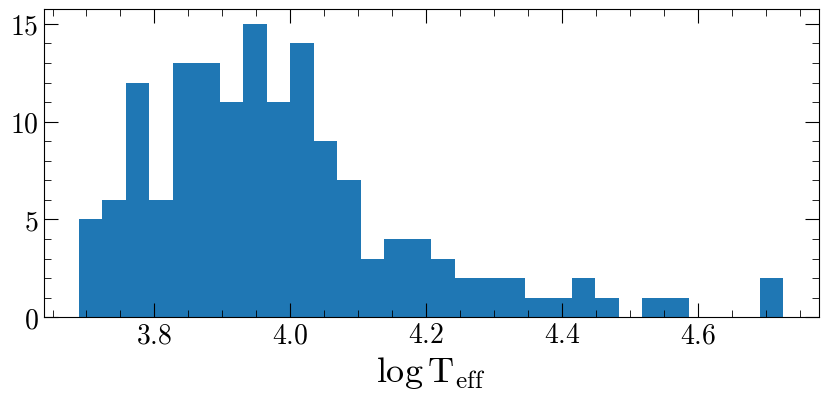

In [8]:
plt.figure(figsize=(10,4))
plt.hist(np.log10(teffs), bins=30)
plt.xlabel(r'$\log T_{eff}$')

In [14]:
zz_ceti_candidate = np.all([np.array(teffs) < 14300, np.array(teffs) > 11000], axis=0)
targets['teff'] = teffs
targets['logteff'] = np.log10(teffs)
targets[zz_ceti_candidate].write('zz_ceti_candidate.csv', overwrite=True)